In [2]:
# Follows the steps of Damiano 2018, Sec. 5.3

"""
1. normalize each spectrum of each detector dividing by its median
2. take the mean spectrum of each detector
3. take all lines <0.8 & also in telluric template
4. fit each line to a gaussian, take the centroid
5. plot pixel position vs. wavelength
6. fit a polynomial to the centroid positions until no correlated residuals
7. find fit precision: deltaV (velocity) = std(residuals) * speed of light / central spectrum wavelength
8. interpolate all single spectra by a third order spline to derived wavelength grid (converting pixel to wavelength via the fit eqn)

"""

'\n1. normalize each spectrum of each detector dividing by its median\n2. take the mean spectrum of each detector\n3. take all lines <0.8 & also in telluric template\n4. fit each line to a gaussian, take the centroid\n5. plot pixel position vs. wavelength\n6. fit a polynomial to the centroid positions until no correlated residuals\n7. find fit precision: deltaV (velocity) = std(residuals) * speed of light / central spectrum wavelength\n8. interpolate all single spectra by a third order spline to derived wavelength grid (converting pixel to wavelength via the fit eqn)\n\n'

In [3]:
import matplotlib.pyplot as plt

plt.rcParams.update({'axes.linewidth' : 1.5,
                     'ytick.major.width' : 1.5,
                     'ytick.minor.width' : 1.5,
                     'xtick.major.width' : 1.5,
                     'xtick.minor.width' : 1.5,
                     'xtick.labelsize': 12, 
                     'ytick.labelsize': 12,
                     'axes.labelsize': 18,
                     'axes.labelpad' : 5,
                     'axes.titlesize' : 22,
                     'axes.titlepad' : 10,
                     'font.family': 'Serif'
                    })

flux, wavelength array shape (31, 14336) (31, 14336)
masked flux, pixel array shape (31, 14309) (14309,)


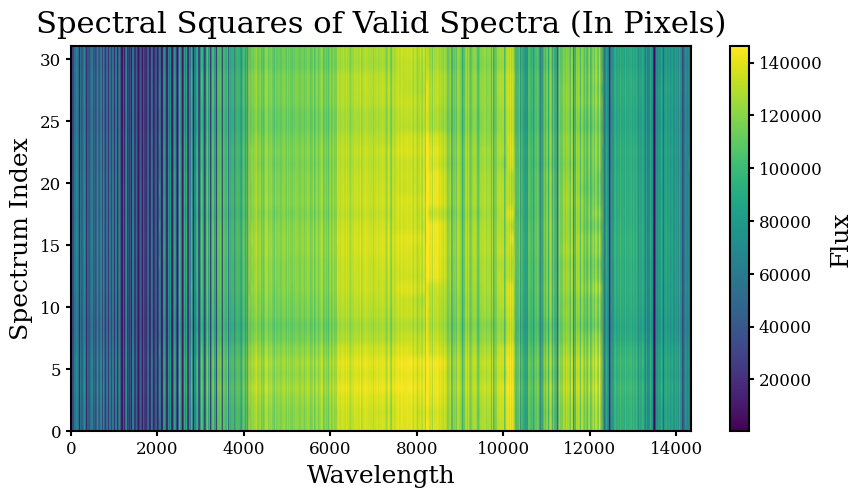

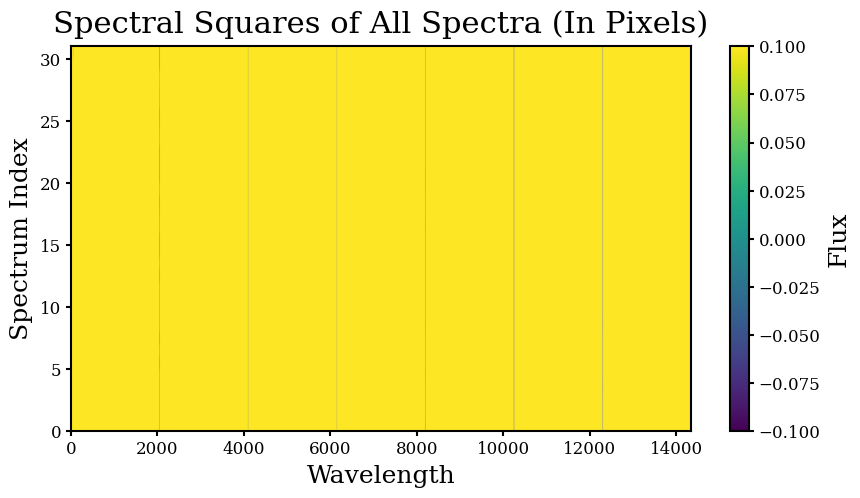

min max of valid flux (-231456.3804420969, 980639.0105325861)
min max of unmasked flux (-231456.3804420969, 980639.0105325861)


In [4]:

#1.1 load data
import numpy as np
from pca_diagnostics import *

data = np.load("/home/ktpha/chile-tellurics/pre/full_spectra/stacked_spectra_perstep.npz")
flux = data['flux']
wave = data['wave']
pixels = np.arange(wave.shape[1]) if wave.ndim == 2 else np.arange(wave.shape[0])

valid_mask = ~np.isnan(flux).any(axis=0)  # Mask out nans

print("flux, wavelength array shape", flux.shape, wave.shape)

print("masked flux, pixel array shape", flux[:, valid_mask].shape, pixels[valid_mask].shape)

plot_spectral_square(flux[:, valid_mask], pixels[valid_mask], title="Spectral Squares of Valid Spectra (In Pixels)")
plot_spectral_square(flux, pixels, title="Spectral Squares of All Spectra (In Pixels)")
print("min max of valid flux", (np.min(flux[:, valid_mask]), np.max(flux[:, valid_mask])))
print("min max of unmasked flux", (np.nanmin(flux), np.nanmax(flux)))

# PIXELS, not wavelength

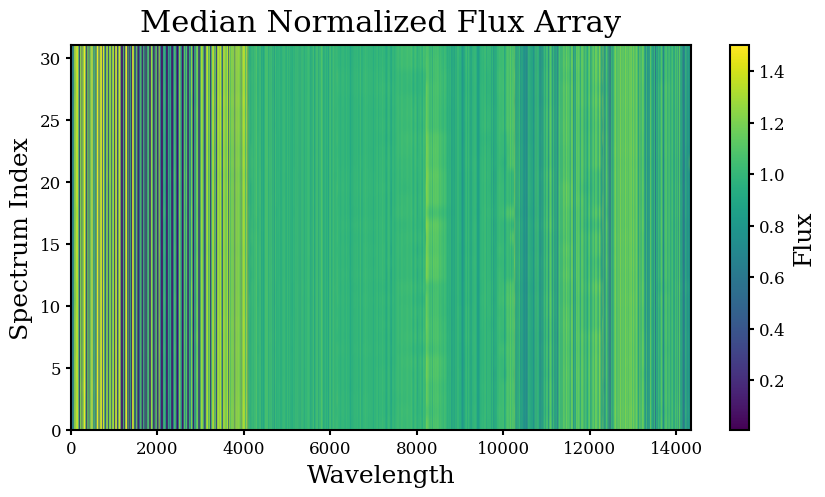

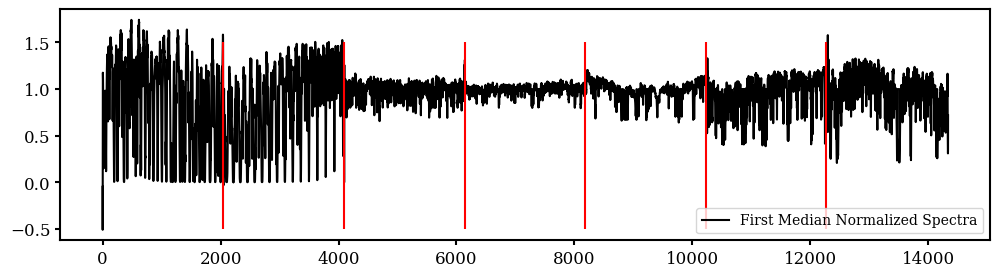

In [5]:
# 1.2 divide each spectrum of each detector by its median
from crires_functions import split_divide_by_median

valid_flux = flux[:, valid_mask]
valid_pixels = pixels[valid_mask]
valid_wave = wave[:, valid_mask]

normalized_flux_array = []
gaps_arr = []  # Store gaps for each spectrum

for ii in range(len(valid_flux)):
    orig_flux = valid_flux[ii, :]
    
    orig_norm_flux, gaps = split_divide_by_median(valid_wave[0], orig_flux, 5)
    
    normalized_flux_array.append(orig_norm_flux)
    gaps_arr.append(gaps)

plot_spectral_square(np.array(normalized_flux_array), valid_pixels, title="Median Normalized Flux Array")

plt.figure(figsize=(12, 3))
plt.plot(valid_pixels, np.array(normalized_flux_array)[0], label="First Median Normalized Spectra", color='black')
for line in gaps_arr[0]:
    plt.vlines(line, ymin=-0.5, ymax=1.5, color='red')
plt.legend()
#plt.xlim(10220, 12280)
plt.show()

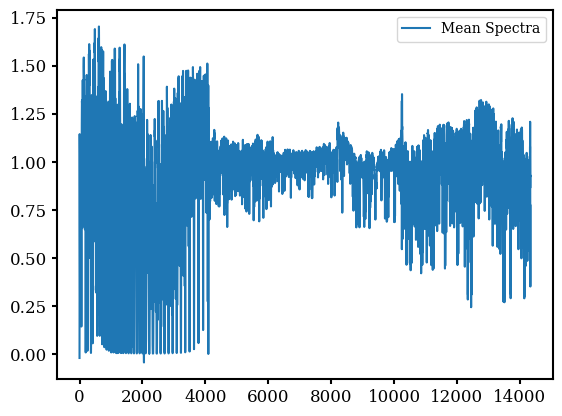

In [6]:
# 2 Take the mean spectrum of each detector

mean_flux = np.nanmean(normalized_flux_array, axis=0)
plt.plot(valid_pixels, mean_flux, label="Mean Spectra")
plt.legend()
plt.show()

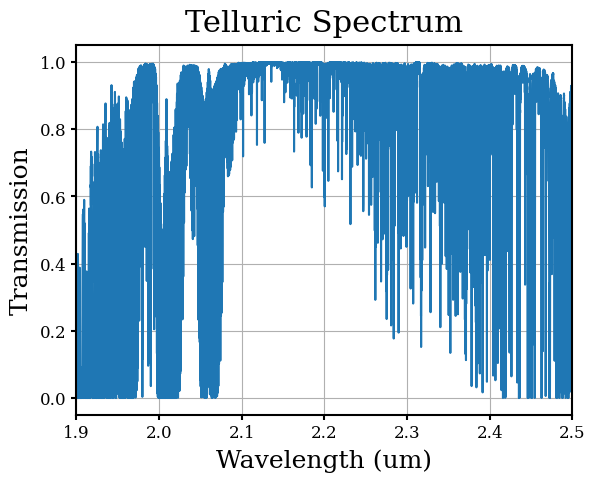

In [7]:
# 3.1.1 Load telluric spectrum
from astropy.io import fits

telluric_spectrum = "/home/ktpha/chile-tellurics/eso_skycalc_tellurics/LBL_A15_s0_R0060000_T.fits"

with fits.open(telluric_spectrum) as hdul:
    telluric_wave = hdul[1].data['lam'] 
    telluric_flux = hdul[1].data['trans'] 

plt.plot(telluric_wave, telluric_flux)
plt.title("Telluric Spectrum")
plt.xlabel("Wavelength (um)")
plt.ylabel("Transmission")
plt.xlim(1.9, 2.5) # approx. crires+ range
plt.grid()
plt.show()

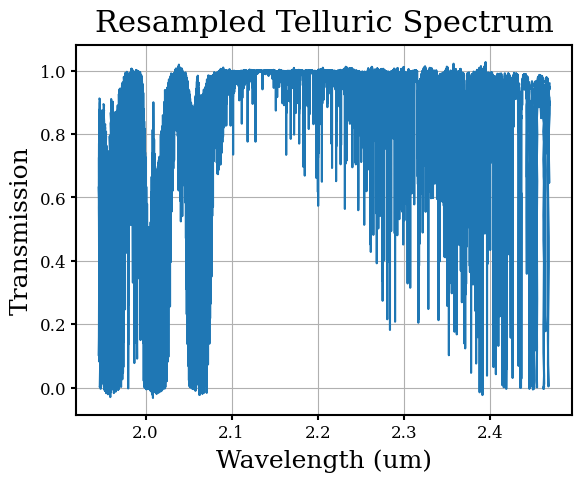

In [8]:
# 3.1.2 interpolate tellurics to ~data from the given wavelength range
from scipy.signal import resample

# Mask telluric arrays to the wavelength range of the data wavelength array, then resample to the shape of the data arrays

# Get min/max wavelength from the data wavelength array (flatten if 2D)
data_wave = wave[0]
data_wave_min = np.min(data_wave) * 0.001
data_wave_max = np.max(data_wave) * 0.001

# Mask telluric arrays to this range
mask = (telluric_wave >= data_wave_min) & (telluric_wave <= data_wave_max)
telluric_wave_masked = telluric_wave[mask]
telluric_flux_masked = telluric_flux[mask]

# Resample telluric arrays to match the shape of the data arrays
telluric_wave_resampled = resample(telluric_wave_masked, len(valid_pixels))
telluric_flux_resampled = resample(telluric_flux_masked, len(valid_pixels))

plt.plot(telluric_wave_resampled, telluric_flux_resampled)
plt.title("Resampled Telluric Spectrum")
plt.xlabel("Wavelength (um)")
plt.ylabel("Transmission")
plt.grid()
plt.show()

In [9]:
from scipy.signal import find_peaks
import numpy as np

# 3.2 Isolate data peaks <0.8
all_peaks, _ = find_peaks(-mean_flux)  # Find minima
data_peaks = all_peaks[mean_flux[all_peaks] < 0.8]

# 3.3 Isolate top-N deepest telluric peaks
all_tel_peaks, _ = find_peaks(-telluric_flux_resampled)
peak_fluxes = telluric_flux_resampled[all_tel_peaks]

N = len(data_peaks)
top_idx = np.argsort(peak_fluxes)[:N]              # deepest N
tel_peaks_unsorted = all_tel_peaks[top_idx]

# Sort by wavelength (assuming telluric_wavelength is defined)
tel_wavelengths = telluric_wave_resampled[tel_peaks_unsorted]
sorted_idx = np.argsort(tel_wavelengths)

tel_peaks = tel_peaks_unsorted[sorted_idx]         # final sorted indices


In [10]:
# 4 fit peaks to gaussians

from scipy.optimize import curve_fit

def gaussian(x, amp, mu, sigma, offset):
    return amp * np.exp(-0.5 * ((x - mu) / sigma) ** 2) + offset

def fit_gaussian_to_peaks(x, y, peaks, window=5):
    centroids = []
    for idx in peaks:
        left = max(0, idx - window)
        right = min(len(x), idx + window + 1)
        x_fit = x[left:right]
        y_fit = y[left:right]
        # Initial guesses
        amp_guess = np.min(y_fit) - np.median(y_fit)
        mu_guess = x[idx]
        sigma_guess = (x_fit[-1] - x_fit[0]) / 6 if len(x_fit) > 1 else 1
        offset_guess = np.median(y_fit)
        try:
            popt, _ = curve_fit(
                gaussian, x_fit, y_fit,
                p0=[amp_guess, mu_guess, sigma_guess, offset_guess]
            )
            centroids.append(popt[1])
        except Exception:
            centroids.append(mu_guess)
    return np.array(centroids)

# 4.1 fit data peaks to gaussians
data_centroids = fit_gaussian_to_peaks(valid_pixels, mean_flux, data_peaks)
tel_centroids = fit_gaussian_to_peaks(telluric_wave_resampled, telluric_flux_resampled, tel_peaks)


/tmp/ipykernel_8696/454073444.py:21: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(


In [11]:
# 5.1.1 Separate data_centroids by the gaps they fall into

# data_centroids are pixel indices; use valid_pixels[data_centroids] if needed for mapping to pixel values
# If you want to use the pixel values directly, use data_centroids as is

sep_data_centroids = []
gaps_with_ends = np.concatenate(([0], gaps, [valid_pixels[-1]]))  # prepend 0 for the first segment

for i in range(len(gaps_with_ends) - 1):
    start = gaps_with_ends[i]
    end = gaps_with_ends[i + 1]
    # Select centroids that fall within this segment
    mask = (data_centroids >= start) & (data_centroids < end)
    sep_data_centroids.append(data_centroids[mask])

# sep_data_centroids is a list of arrays, one per segment
for idx, arr in enumerate(sep_data_centroids):
    print(f"Segment {idx}: {len(arr)} centroids")

segment_centroids = {seg_id: arr for seg_id, arr in enumerate(sep_data_centroids)}

# 1. Get segment lengths from data_centroids
segment_lengths = [len(arr) for arr in segment_centroids.values()]

# 2. Split telluric_centroids into matching segments
split_tel_centroids = np.split(tel_centroids, np.cumsum(segment_lengths)[:-1])

# 3. Build dict with same keys as segment_centroids
tel_centroid_dict = {i: seg for i, seg in enumerate(split_tel_centroids)}


Segment 0: 72 centroids
Segment 1: 70 centroids
Segment 2: 29 centroids
Segment 3: 0 centroids
Segment 4: 34 centroids
Segment 5: 92 centroids
Segment 6: 78 centroids


1.94696943 - (2.34870289e-06)·x + (4.4351774e-08)·x² -
(6.17911327e-11)·x³ + (3.4083712e-14)·x⁴ - (6.43590339e-18)·x⁵
12.59602933 - 0.01844171·x + (1.25234966e-05)·x² - (4.16664735e-09)·x³ +
(6.81326328e-13)·x⁴ - (4.38988053e-17)·x⁵
10.31341397 - 0.00858279·x + (3.51864585e-06)·x² - (7.15852156e-10)·x³ +
(7.23060352e-14)·x⁴ - (2.90128156e-18)·x⁵
544.73552327 - 0.28753642·x + (6.08219443e-05)·x² - (6.42099329e-09)·x³ +
(3.38318886e-13)·x⁴ - (7.11740761e-18)·x⁵
-58614.08401054 + 26.15529557·x - 0.00466225·x² + (4.14983159e-07)·x³ -
(1.84442592e-11)·x⁴ + (3.27476624e-16)·x⁵
-32798.56406326 + 12.32211604·x - 0.00185015·x² + (1.3879078e-07)·x³ -
(5.2018102e-12)·x⁴ + (7.79263306e-17)·x⁵


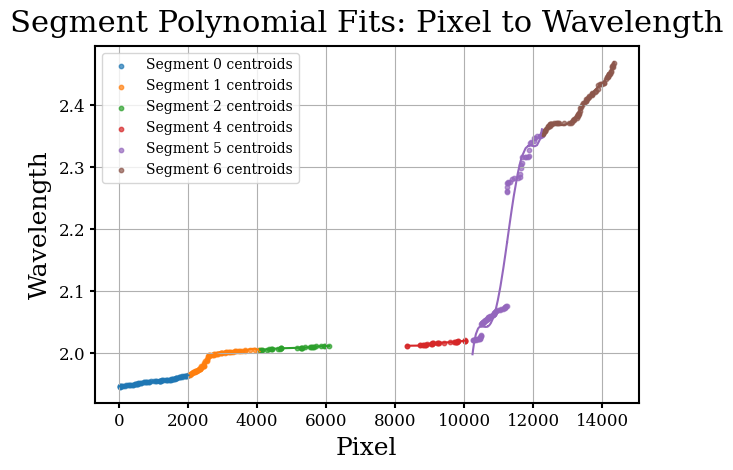

In [12]:
# 5, 6

from scipy.interpolate import interp1d
from numpy.polynomial import Polynomial
import matplotlib.pyplot as plt

def fit_segments_to_wavelengths(segment_centroids, tel_centroids, telluric_wavelength, deg=3):
    fits = {}

    pixel_grid = np.arange(len(telluric_wavelength))
    interp_wave = interp1d(pixel_grid, telluric_wavelength, kind='linear', bounds_error=False, fill_value=np.nan)

    # Interpolator: wavelength to pixel index
    interp_idx = interp1d(telluric_wavelength, np.arange(len(telluric_wavelength)), 
                      kind='linear', bounds_error=False, fill_value=np.nan)

    tel_centroids_pixel = {seg_id: interp_idx(waves) for seg_id, waves in tel_centroid_dict.items()}

    for seg_id in segment_centroids:
        data_pix = segment_centroids[seg_id]
        tel_pix = tel_centroids_pixel[seg_id]

        # Skip if either segment is empty
        if len(data_pix) == 0 or len(tel_pix) == 0:
            continue

        # Interpolate wavelength at telluric centroids
        wave_vals = interp_wave(tel_pix)

        # Fit pixel → wavelength
        mask = ~np.isnan(data_pix) & ~np.isnan(wave_vals)
        p = Polynomial.fit(data_pix[mask], wave_vals[mask], deg=deg).convert()
        print(p)
        fits[seg_id] = p

    return fits

# Run the fit
segment_fits = fit_segments_to_wavelengths(segment_centroids, tel_centroid_dict, telluric_wave_resampled, deg=5)

# Plot fits for inspection
for seg_id, poly in segment_fits.items():
    x = segment_centroids[seg_id]
    y_fit = poly(x)
    y_true = tel_centroid_dict[seg_id]

    plt.plot(x, y_fit)
    plt.scatter(x, y_true, s=10, alpha=0.7, label=f"Segment {seg_id} centroids")

plt.xlabel("Pixel")
plt.ylabel("Wavelength")
plt.title("Segment Polynomial Fits: Pixel to Wavelength")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


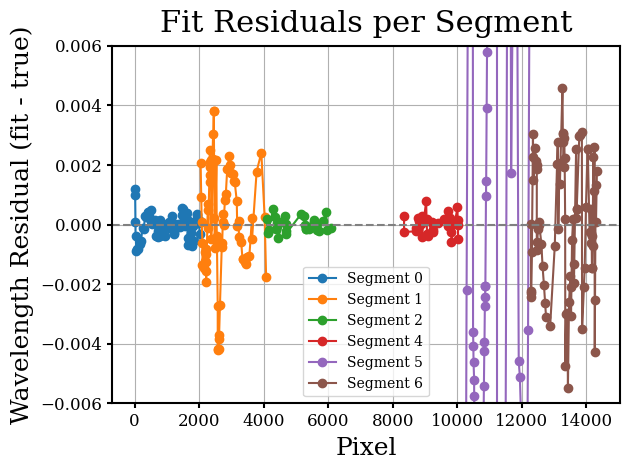

In [13]:
#6

residuals_dict = {}

for seg_id, poly in segment_fits.items():
    pixels = np.atleast_1d(segment_centroids[seg_id])
    true_wavelengths = np.atleast_1d(tel_centroid_dict[seg_id])

    if len(pixels) != len(true_wavelengths):
        print(f"Skipping segment {seg_id}: mismatched lengths")
        continue

    # Evaluate fit
    fitted_wavelengths = poly(pixels)
    residuals = fitted_wavelengths - true_wavelengths
    residuals_dict[seg_id] = residuals

    # Optional: plot residuals
    plt.plot(pixels, residuals, 'o-', label=f'Segment {seg_id}')

plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Pixel")
plt.ylabel("Wavelength Residual (fit - true)")
plt.title("Fit Residuals per Segment")
plt.legend()
plt.grid(True)
plt.ylim(-0.006, 0.006)
plt.tight_layout()
plt.show()


In [14]:
# 7
from astropy.constants import c

def precision(residuals, wave_arr):
    std = np.std(residuals)
    central_wave = np.median(wave_arr)
    return std * c / (central_wave)


segment_precision = {}

for seg_id, residual in residuals_dict.items():
    
    pix = segment_centroids[seg_id]
    if len(pix) == 0:
        continue

    # Use full pixel span for this segment
    full_pix_range = np.arange(int(np.min(pix)), int(np.max(pix)) + 1)

    # Evaluate fitted poly at full pixel range
    fitted_waves = poly(full_pix_range)

    # Remove any nan pairs
    mask = ~np.isnan(fitted_waves) 

    # Compute precision
    prec = precision(residual, fitted_waves[mask])
    segment_precision[seg_id] = prec

    print(f"Segment {seg_id}: precision = {prec:.3f}")



Segment 0: precision = -5.226 m / s
Segment 1: precision = -62.393 m / s
Segment 2: precision = -24.185 m / s
Segment 4: precision = -1013.609 m / s
Segment 5: precision = 154574414.053 m / s
Segment 6: precision = 279144.927 m / s


In [15]:
# 5.1.1 Separate mean flux array by detectors

def split_and_stack(arr, gaps):
    segments = []
    gaps = np.concatenate(([0], gaps))
    for i in range(len(gaps) - 1):
        segments.append(arr[gaps[i]:gaps[i + 1]].astype(float))  # cast to float
    segments.append(arr[gaps[-1]:].astype(float))
    maxlen = max(len(seg) for seg in segments)
    stacked = np.array([np.pad(seg, (0, maxlen - len(seg)), constant_values=np.nan) for seg in segments])
    return stacked

# Example usage:
sep_mean_flux = split_and_stack(mean_flux, gaps_arr[0])
sep_pixels = split_and_stack(valid_pixels, gaps_arr[0])
sep_tel_wav = split_and_stack(telluric_wave_resampled, gaps_arr[0])

print("sep_mean_flux shape:", sep_mean_flux.shape)
print("sep_tel_wav shape:", sep_tel_wav.shape)

sep_mean_flux shape: (7, 2047)
sep_tel_wav shape: (7, 2047)


/tmp/ipykernel_8696/2827443198.py:9: RuntimeWarning: invalid value encountered in cast
  pixels = pixels.astype(int)


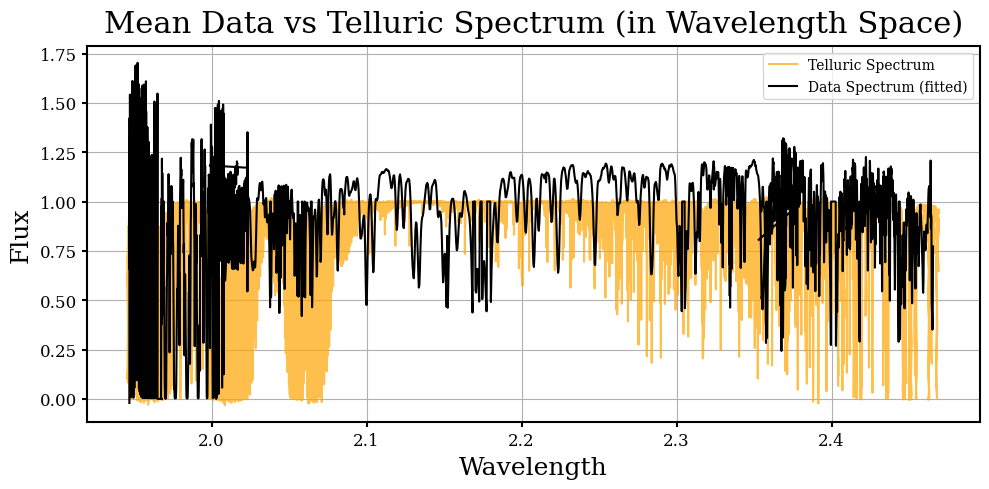

In [16]:
import matplotlib.pyplot as plt
import numpy as np

data_wavelengths = np.full_like(mean_flux, np.nan, dtype=float)

# 1. Convert each segment's pixels to wavelength using fitted polynomials
for seg_id, poly in segment_fits.items():
    pixels = sep_pixels[seg_id]
    pixels = pixels.astype(int)

    # Ensure we don't go out of bounds
    pixels = pixels[(pixels >= 0) & (pixels < len(mean_flux))]
    data_wavelengths[pixels] = poly(pixels)

# 3. Plot in wavelength space
plt.figure(figsize=(10, 5))

plt.plot(telluric_wave_resampled, telluric_flux_resampled, label="Telluric Spectrum", color="orange", alpha=0.7)
plt.plot(data_wavelengths, mean_flux, label="Data Spectrum (fitted)", color="black")

plt.xlabel("Wavelength")
plt.ylabel("Flux")
plt.title("Mean Data vs Telluric Spectrum (in Wavelength Space)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


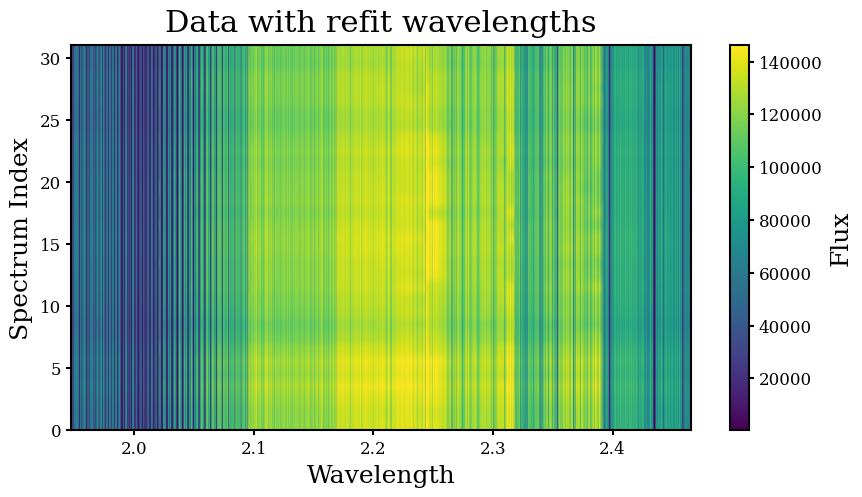

In [17]:
# 8
plot_spectral_square(valid_flux, data_wavelengths, title="Data with refit wavelengths")


In [18]:
from calibration import calibrate_cr2res

dat_wav = calibrate_cr2res(wave[0] * 0.001, flux, telluric_wave, telluric_flux, gap_size_px=5, poly_order=5)

flux, wavelength array shape (31, 14336) (14336,)
masked flux, pixel array shape (31, 14309) (14309,)


/home/ktpha/chile-tellurics/code/calibration.py:41: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(


Segment 0: 72 centroids
Segment 1: 70 centroids
Segment 2: 29 centroids
Segment 3: 0 centroids
Segment 4: 34 centroids
Segment 5: 92 centroids
Segment 6: 78 centroids
1.94696943 - (2.34870289e-06)·x + (4.4351774e-08)·x² -
(6.17911327e-11)·x³ + (3.4083712e-14)·x⁴ - (6.43590339e-18)·x⁵
12.59602933 - 0.01844171·x + (1.25234966e-05)·x² - (4.16664735e-09)·x³ +
(6.81326328e-13)·x⁴ - (4.38988053e-17)·x⁵
10.31341397 - 0.00858279·x + (3.51864585e-06)·x² - (7.15852156e-10)·x³ +
(7.23060352e-14)·x⁴ - (2.90128156e-18)·x⁵
544.73552327 - 0.28753642·x + (6.08219443e-05)·x² - (6.42099329e-09)·x³ +
(3.38318886e-13)·x⁴ - (7.11740761e-18)·x⁵
-58614.08401054 + 26.15529557·x - 0.00466225·x² + (4.14983159e-07)·x³ -
(1.84442592e-11)·x⁴ + (3.27476624e-16)·x⁵
-32798.56406326 + 12.32211604·x - 0.00185015·x² + (1.3879078e-07)·x³ -
(5.2018102e-12)·x⁴ + (7.79263306e-17)·x⁵


/home/ktpha/chile-tellurics/code/calibration.py:250: RuntimeWarning: invalid value encountered in cast
  pixels = pixels.astype(int)


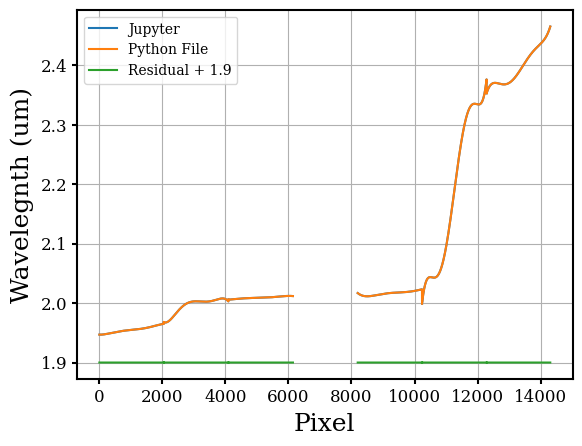

In [24]:
plt.plot(data_wavelengths, label="Jupyter")
plt.plot(dat_wav, label="Python File")
plt.plot(data_wavelengths - dat_wav + 1.9, label="Residual + 1.9")
plt.legend()
plt.grid()
plt.xlabel("Pixel")
plt.ylabel("Wavelegnth (um)")
plt.show()